# SRGAN 

### instructions to run the video converter
```
0. upload this notebook to Google Colab
1. upload your video
2. replace "/content/lrvideo.3gp" with your input file path
Run all cells sequentially(you can skip plotting examples & model plotting) you will get the result at "creating output video" section. the result will be saved as hrvideo_output.mp4
```

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from __future__ import print_function, division
import scipy
from tensorflow_addons.layers import InstanceNormalization
from uuid import uuid4
from tensorflow.keras.datasets import mnist
# from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from tensorflow.keras.layers import Add, BatchNormalization, Conv2D, Dense, Flatten, Input, LeakyReLU, PReLU, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
import datetime
import matplotlib.pyplot as plt
import sys
from PIL import Image

import os
from glob import glob
import numpy as np
# Importing all necessary libraries 
import timeit
import cv2 

import tensorflow.keras.backend as K
import tensorflow as tf

In [ ]:
import requests
with open("weights-srgan.tar.gz", "wb") as wf:
    wf.write(requests.get("https://martin-krasser.de/sisr/weights-srgan.tar.gz").content)

In [ ]:
with open("cat.png", "wb") as cpic:
    cpic.write(requests.get("https://github.com/krasserm/super-resolution/blob/master/demo/0869x4-crop.png?raw=true").content)

In [ ]:
!tar xvfz /content/weights-srgan.tar.gz

weights/srgan/gan_discriminator.h5
weights/srgan/gan_generator.h5
weights/srgan/pre_generator.h5


In [ ]:
DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255
def resolve_single(model, lr):
    return resolve(model, tf.expand_dims(lr, axis=0))[0]


def resolve(model, lr_batch):
    lr_batch = tf.cast(lr_batch, tf.float32)
    sr_batch = model(lr_batch)
    sr_batch = tf.clip_by_value(sr_batch, 0, 255)
    sr_batch = tf.round(sr_batch)
    sr_batch = tf.cast(sr_batch, tf.uint8)
    return sr_batch


def evaluate(model, dataset):
    psnr_values = []
    for lr, hr in dataset:
        sr = resolve(model, lr)
        psnr_value = psnr(hr, sr)[0]
        psnr_values.append(psnr_value)
    return tf.reduce_mean(psnr_values)


# ---------------------------------------
#  Normalization
# ---------------------------------------


def normalize(x, rgb_mean=DIV2K_RGB_MEAN):
    return (x - rgb_mean) / 127.5


def denormalize(x, rgb_mean=DIV2K_RGB_MEAN):
    return x * 127.5 + rgb_mean


def normalize_01(x):
    """Normalizes RGB images to [0, 1]."""
    return x / 255.0


def normalize_m11(x):
    """Normalizes RGB images to [-1, 1]."""
    return x / 127.5 - 1


def denormalize_m11(x):
    """Inverse of normalize_m11."""
    return (x + 1) * 127.5


# ---------------------------------------
#  Metrics
# ---------------------------------------


def psnr(x1, x2):
    return tf.image.psnr(x1, x2, max_val=255)


# ---------------------------------------
#  See https://arxiv.org/abs/1609.05158
# ---------------------------------------


def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

In [ ]:
LR_SIZE = 24
HR_SIZE = 96


def upsample(x_in, num_filters):
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x_in)
    x = Lambda(pixel_shuffle(scale=2))(x)
    return PReLU(shared_axes=[1, 2])(x)


def res_block(x_in, num_filters, momentum=0.8):
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x_in)
    x = BatchNormalization(momentum=momentum)(x)
    x = PReLU(shared_axes=[1, 2])(x)
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization(momentum=momentum)(x)
    x = Add()([x_in, x])
    return x


def sr_resnet(num_filters=64, num_res_blocks=16):
    x_in = Input(shape=(None, None, 3))
    x = Lambda(normalize_01)(x_in)

    x = Conv2D(num_filters, kernel_size=9, padding='same')(x)
    x = x_1 = PReLU(shared_axes=[1, 2])(x)

    for _ in range(num_res_blocks):
        x = res_block(x, num_filters)

    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x_1, x])

    x = upsample(x, num_filters * 4)
    x = upsample(x, num_filters * 4)

    x = Conv2D(3, kernel_size=9, padding='same', activation='tanh')(x)
    x = Lambda(denormalize_m11)(x)

    return Model(x_in, x)


generator = sr_resnet


def discriminator_block(x_in, num_filters, strides=1, batchnorm=True, momentum=0.8):
    x = Conv2D(num_filters, kernel_size=3, strides=strides, padding='same')(x_in)
    if batchnorm:
        x = BatchNormalization(momentum=momentum)(x)
    return LeakyReLU(alpha=0.2)(x)


def discriminator(num_filters=64):
    x_in = Input(shape=(HR_SIZE, HR_SIZE, 3))
    x = Lambda(normalize_m11)(x_in)

    x = discriminator_block(x, num_filters, batchnorm=False)
    x = discriminator_block(x, num_filters, strides=2)

    x = discriminator_block(x, num_filters * 2)
    x = discriminator_block(x, num_filters * 2, strides=2)

    x = discriminator_block(x, num_filters * 4)
    x = discriminator_block(x, num_filters * 4, strides=2)

    x = discriminator_block(x, num_filters * 8)
    x = discriminator_block(x, num_filters * 8, strides=2)

    x = Flatten()(x)

    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)

    return Model(x_in, x)


def vgg_22():
    return _vgg(5)


def vgg_54():
    return _vgg(20)


def _vgg(output_layer):
    vgg = VGG19(input_shape=(None, None, 3), include_top=False)
    return Model(vgg.input, vgg.layers[output_layer].output)

In [ ]:
model = generator()

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.load_weights("/content/weights/srgan/gan_generator.h5")

In [ ]:
def load_image(path):
    return np.array(Image.open(path))

def plot_sample(lr, sr):
    plt.figure(figsize=(20, 10))

    images = [lr, sr]
    titles = ['LR', f'SR (x{sr.shape[0] // lr.shape[0]})']

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 2, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

In [ ]:
def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    
    gan_sr = resolve_single(model, lr)
    print(lr.shape, gan_sr.shape)
    
    plt.figure(figsize=(20, 20))
    
    images = [lr, gan_sr]
    titles = ['LR', 'SR (GAN)']
    positions = [1, 2]
    
    for i, (img, title, pos) in enumerate(zip(images, titles, positions)):
        plt.subplot(2, 2, pos)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

(118, 124, 3) (472, 496, 3)


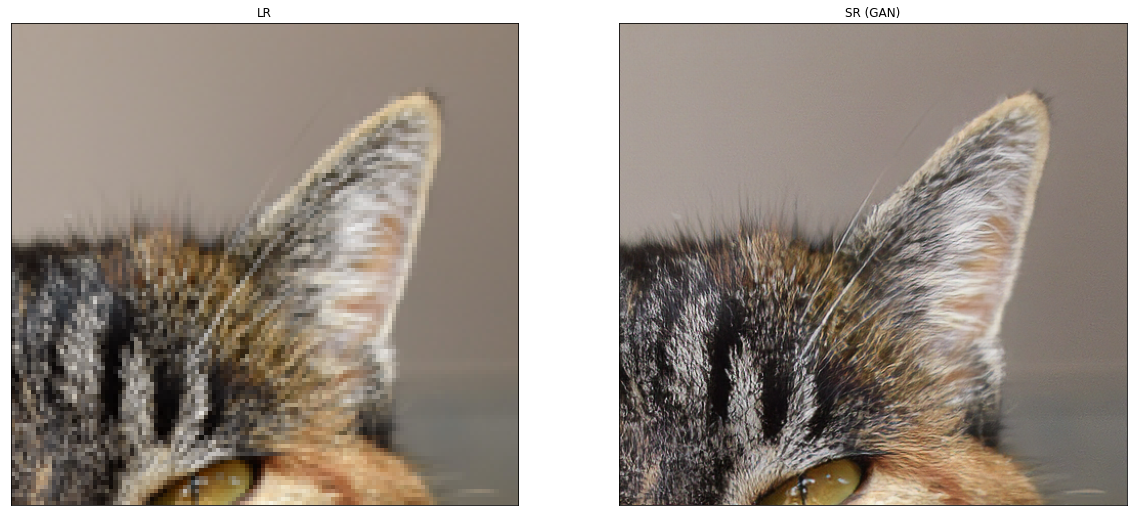

In [ ]:
resolve_and_plot("/content/cat.png")

### some more tests

In [ ]:
def dwnldimg(fn, url):
    try:
        with open(fn, 'wb') as f:
            f.write(requests.get(url).content)
        print("downloaded")
    except:
        print('some error in downloading or saving')

In [ ]:
dwnldimg('hf.jpg', 
         "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRVGlSO4VwyW64x86sFJ4Tkzf2vyLANlSUOTw&usqp=CAU")

downloaded


(192, 262, 3) (768, 1048, 3)


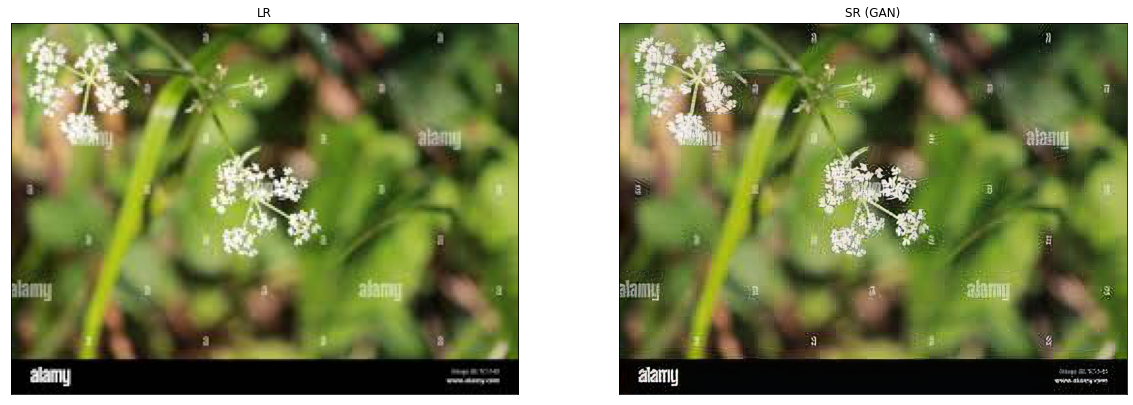

In [ ]:
resolve_and_plot("/content/hf.jpg")

In [ ]:
dwnldimg('hf1.jpg', 
         "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS77a8S_0Skc38x12YXmx3T4iepXBi9gDi3yw&usqp=CAU")

downloaded


(188, 268, 3) (752, 1072, 3)


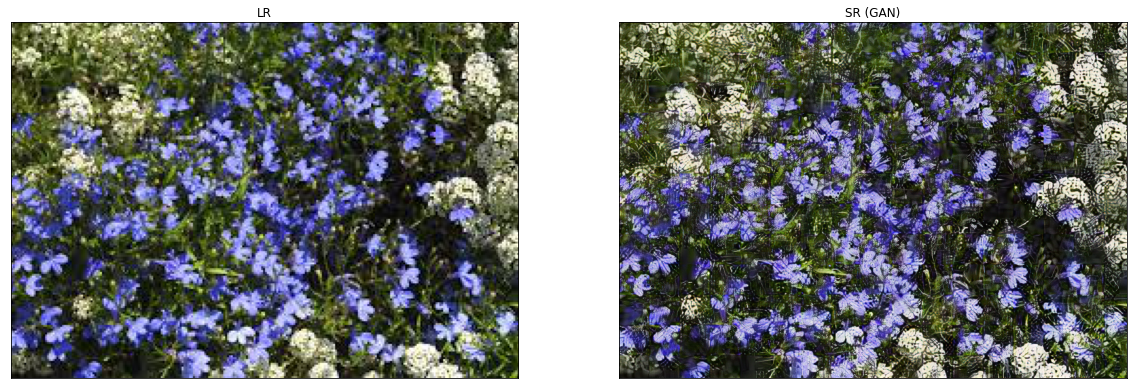

In [ ]:
resolve_and_plot("/content/hf1.jpg")

downloaded
(183, 275, 3) (732, 1100, 3)


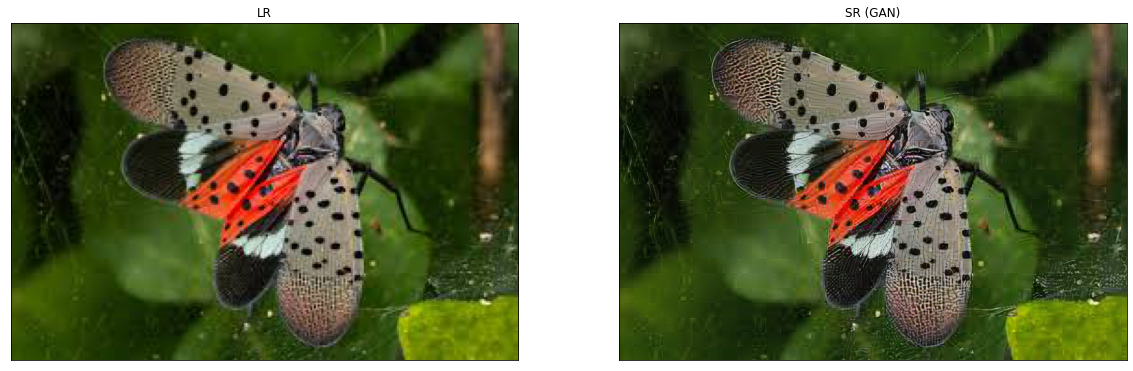

In [ ]:
dwnldimg(
    "hf2.jpg",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQnSvtobOqhy54jAzM71SMGBUfWOMcMVjVpvA&usqp=CAU"
)
resolve_and_plot("/content/hf2.jpg")

downloaded
(259, 194, 3) (1036, 776, 3)


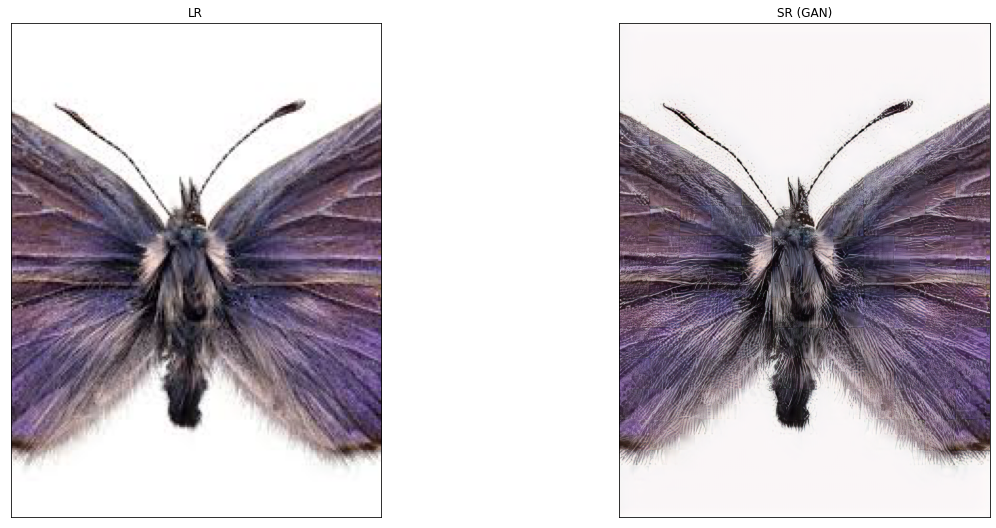

In [ ]:
# https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRlR5oZipYu6fay-60GU5zUGoqG0r2FSKXGNA&usqp=CAU
dwnldimg(
    "hf3.jpg",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRlR5oZipYu6fay-60GU5zUGoqG0r2FSKXGNA&usqp=CAU"
)
resolve_and_plot("/content/hf3.jpg")

In [ ]:
def plot_from_url(url):
    fn = 'netpic' + str(uuid4()) + '.jpg'
    dwnldimg(
        fn, 
        url
    )
    resolve_and_plot(f"/content/{fn}")

downloaded
(234, 216, 3) (936, 864, 3)


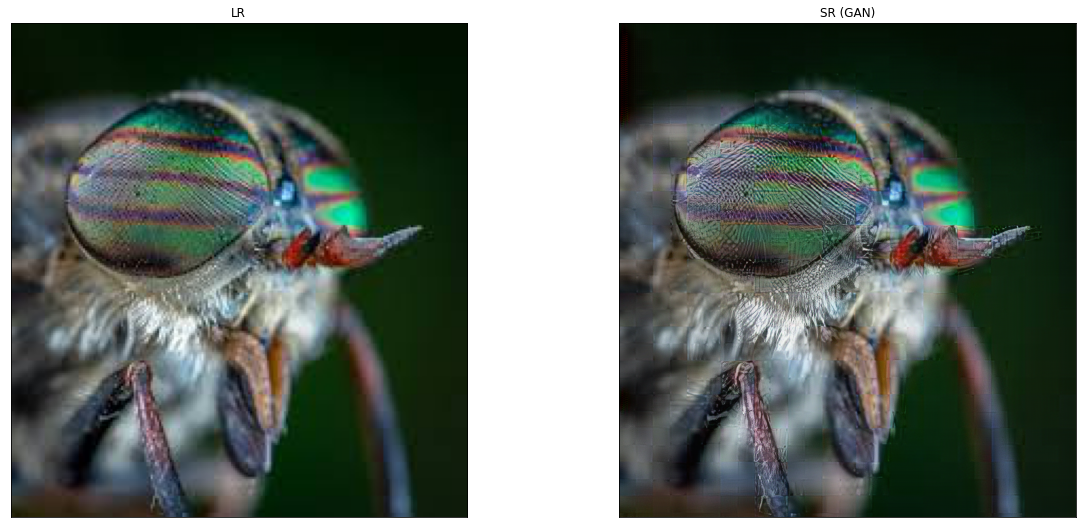

In [ ]:
plot_from_url(
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQrynBS56DCm6Va8hWK4c-wyUOqRnb6bEK58g&usqp=CAU"
)

downloaded
(192, 262, 3) (768, 1048, 3)


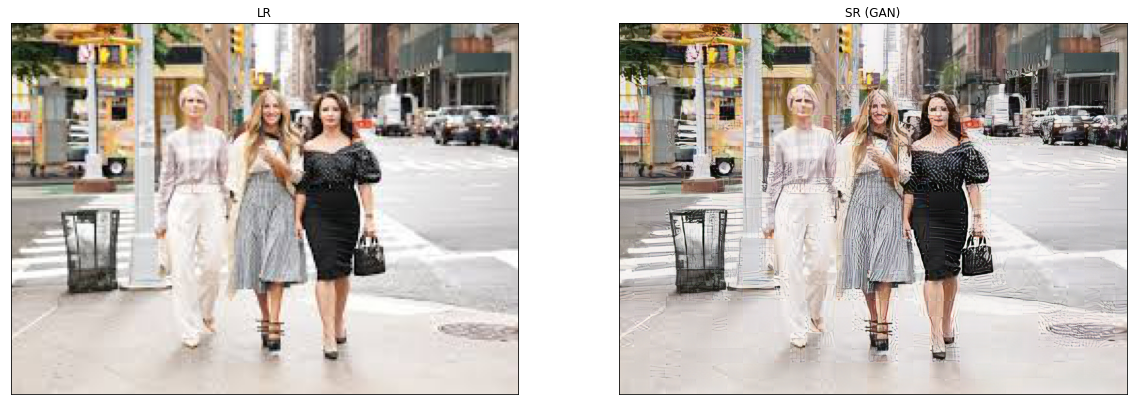

In [ ]:
plot_from_url(
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT-oG_LYkDMa_ZGotu9yBMFyNVBYc5m4mAYow&usqp=CAU"
)

downloaded
(266, 190, 3) (1064, 760, 3)


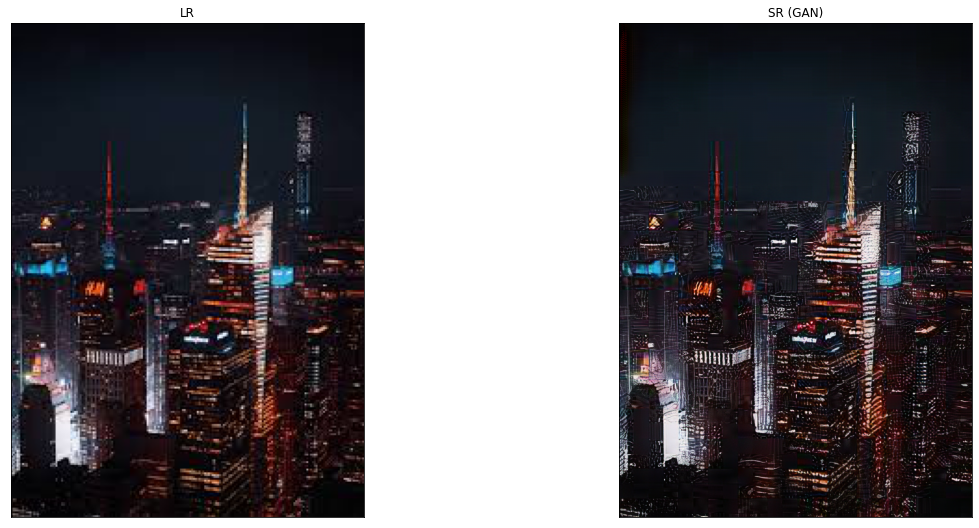

In [ ]:
plot_from_url(
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRwZm2TUcKTWKwPTEvFU7RnbrDTx4tjRFO9jw&usqp=CAU"
)

downloaded
(183, 275, 3) (732, 1100, 3)


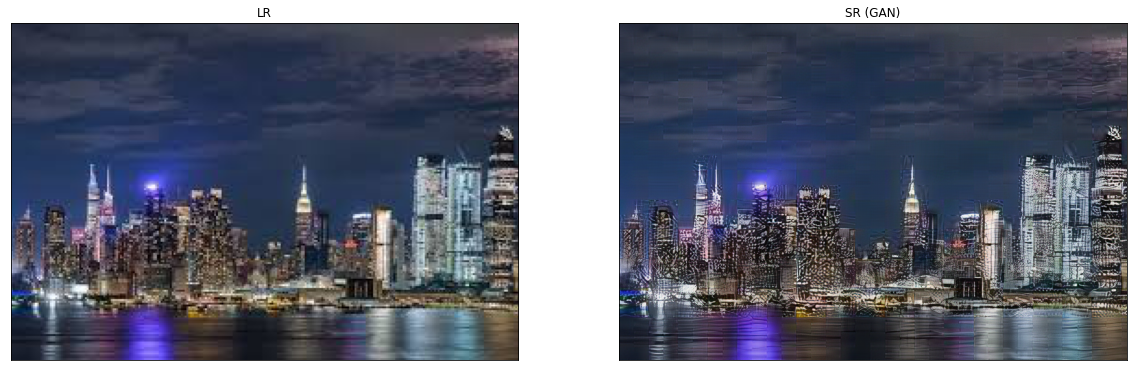

In [ ]:
plot_from_url(
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSPsQ8gKPgYb3Oq2vxe3whhn_nRreJLtXuC2A&usqp=CAU"
)

# Video Conversion

download sample input lr video from [here](https://www38.zippyshare.com/v/IBqxnmEG/file.html)

download corresponding output hr video from [here](https://www38.zippyshare.com/v/rm7OwG7i/file.html)

In [ ]:
# Read the video from specified path 
cam = cv2.VideoCapture("/content/lrvideo.3gp") 
fps = cam.get(cv2.CAP_PROP_FPS)
print(fps)

24.0


In [ ]:
try:
      
    # creating a folder named data 
    if not os.path.exists('data'): 
        os.makedirs('data') 
  
# if not created then raise error 
except OSError:
    print ('Error: Creating directory of data') 

###extracting frames

In [ ]:
#frames Extraction from video 
currentframe = 0
arr_img = []
while(True): 
      
    # reading from frame 
    ret,frame = cam.read() 
  
    if ret: 
        # if video is still left continue creating images 
        name = './data/frame' + str(currentframe).zfill(3) + '.jpg'
  
        # writing the extracted images 
        cv2.imwrite(name, frame) 
  
        # increasing counter so that it will show how many frames are created 
        currentframe += 1
        #storing the path of extracted frames in a list
        arr_img.append(name)
    else: 
        break

### super resolving frames

In [ ]:

start = timeit.default_timer()

#Initialization of an empty list to store the super resolved images
arr_output=[]
print("no. of frames to process:",len(arr_img))
n= len(arr_img)

for i in range(n):
  lr = load_image(arr_img[i])
  sr = resolve_single(model, lr)
  #plot_sample(lr, sr)
  arr_output.append(sr)
  
stop = timeit.default_timer()
#print(arr_output)

print("time : ", stop-start)

# Release all space and windows once done 
cam.release() 
cv2.destroyAllWindows()

no. of frames to process: 128
time :  32.74695215700012


### creating output video

In [ ]:
os.makedirs("output_images")

In [ ]:
s_res= []
for j in range(len(arr_output)):
  out_name = '/content/output_images/frame' + str(j).zfill(3) + '.jpg'
  img_pil = tf.keras.utils.array_to_img(arr_output[j])
  img1 = tf.keras.utils.save_img(out_name, img_pil)
  s_res.append(out_name)

In [ ]:
for i in range(len(s_res)):
    filename=s_res[i]
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
 
fps = 24      
#Calculate by using (No. of frames)/Video_duration in seconds  
             
out = cv2.VideoWriter('hrvideo_output.mp4',cv2.VideoWriter_fourcc(*'DIVX'), fps , size)

for i in range(len(s_res)):
    out.write(cv2.imread(s_res[i]))
out.release()

# superresolve from url

In [ ]:
def plot_save_from_url(url):
    def resolve_save_and_plot(lr_image_path):
        lr = load_image(lr_image_path)
        
        gan_sr = resolve_single(model, lr)
        print(lr.shape, gan_sr.shape)
        img = Image.fromarray(gan_sr.numpy())
        img.save(f'sr_saved{uuid4()}.jpg')
        plt.figure(figsize=(20, 20))
        
        images = [lr, gan_sr]
        titles = ['LR', 'SR (GAN)']
        positions = [1, 2]
        
        for i, (img, title, pos) in enumerate(zip(images, titles, positions)):
            plt.subplot(2, 2, pos)
            plt.imshow(img)
            plt.title(title)
            plt.xticks([])
            plt.yticks([])

    fn = 'netpic_lr' + str(uuid4()) + '.jpg'
    dwnldimg(
        fn, 
        url
    )
    resolve_save_and_plot(f"/content/{fn}")


downloaded
(326, 580, 3) (1304, 2320, 3)


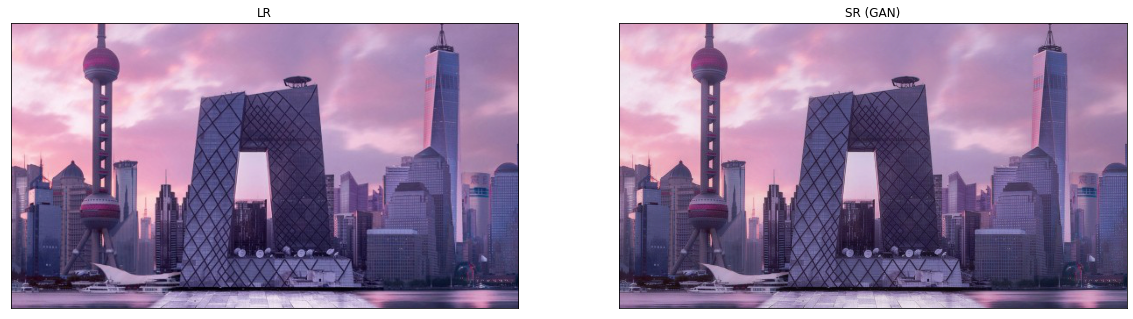

In [ ]:
plot_save_from_url(
   "https://media.springernature.com/w580h326/nature-cms/uploads/collections/NI-2020-Science-Cities_hero-b199a77e980d6b771948f51b35025f3b.jpg"
)

In [ ]:

img = cv2.imread("/content/netpic_lre7d8c8fa-8042-4799-9da6-292db9d73039.jpg")
print(img.shape)


(326, 580, 3)


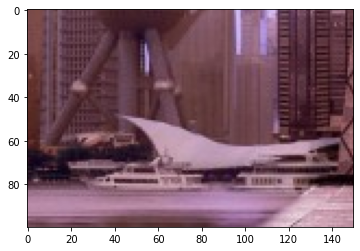

In [ ]:
crop_img = img[226:, 50:200]
plt.imshow(crop_img)

(400, 600, 3)


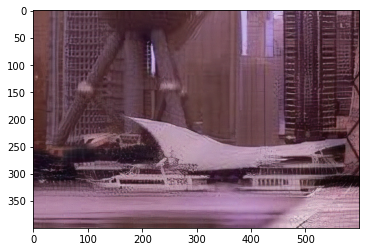

In [ ]:
gan_sr = resolve_single(model, crop_img)
plt.imshow(gan_sr)
print(gan_sr.shape)